In [1]:
import zipfile, py7zr
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
from shapely import LineString
import pickle
from collections import Counter
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import alphashape

import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
from matplotlib import pyplot as plt
import momepy
import networkx as nx
from shapely.geometry import Polygon
import alphashape
from pyproj import Proj, Geod
import ast

data_path = '../../data/'  
polygon_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')

In [2]:
def line_length_in_meters(line_string):
    # Define a UTM projection for the zone containing your coordinates
    utm_zone = 31  # Assuming you are in Paris, which falls in UTM zone 31 for example
    proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Extract coordinates from the LineString
    coordinates = list(line_string.coords)

    # Transform the coordinates to UTM projection
    utm_coordinates = [proj(lon, lat) for lon, lat in coordinates]

    # Compute the distance between consecutive points in meters
    total_length = 0
    geod = Geod(ellps='WGS84')
    for i in range(len(utm_coordinates) - 1):
        lon1, lat1 = utm_coordinates[i]
        lon2, lat2 = utm_coordinates[i + 1]
        distance_meters = geod.inv(lon1, lat1, lon2, lat2)[-1]  # Use [-1] to get distance

        # Handle case of very small distances
        if np.isnan(distance_meters):
            dx = lon2 - lon1
            dy = lat2 - lat1
            distance_meters = np.sqrt(dx**2 + dy**2)
        total_length += distance_meters

    return total_length

def is_na_list(lst):
    return lst is None or len(lst) == 0 or all(pd.isna(x) for x in lst)

def parse_and_average_lanes(lanes_str):
    if isinstance(lanes_str, list):
        if is_na_list(lanes_str):
            return np.nan
        else: 
            return sum(map(int, lanes_str)) / len(lanes_str)
    else:
        if pd.isna(lanes_str):  # Check if input is NaN
            return np.nan  # Return NaN if input is NaN
    try:
        # Attempt to parse the string as a list
        lanes_list = ast.literal_eval(lanes_str)
        if isinstance(lanes_list, list):
            # If it's a list, calculate the average of list elements
            return sum(map(int, lanes_list)) / len(lanes_list)
        else:
            # If it's a single integer, return it as is
            return int(lanes_list)
    except (SyntaxError, ValueError):
        # If parsing fails or the lanes_str is not a list, parse as single integer
        return int(lanes_str)

def approximate_number_of_lanes(df_matched):
    df_matched_with_lanes_approximated = df_matched.copy()
    average_lanes_per_highway = df_matched.groupby('highway')['lanes_mapped'].mean()
    for index, row in df_matched_with_lanes_approximated.iterrows():
        if pd.isna(row['lanes_mapped']):
            df_matched_with_lanes_approximated.at[index, 'lanes_mapped'] = average_lanes_per_highway[row['highway']]
    return df_matched_with_lanes_approximated

This notebook matches the links of the Paris counting network with the links of an OSM network:
- Load [OpenStreetMap network](https://www.openstreetmap.org/#map=7/51.330/10.453)
- Load [detector network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Load networks

In [3]:
# perform it for years 2013 - current year. For some reason, one cannot retrieve detector data from OSM from before 2013.
year = 2013

output_path = "output/detectors_matched_2_osm_01_" + str(year)

In [4]:
# get OSM dataframe
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

overpass_settings = '[out:json][timeout:90][date:"' + str(year) + '-01-01T00:00:00Z"]'
ox.settings.overpass_settings = overpass_settings
ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72663/102334064.py:12: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [5]:
df_osm.drop(columns=['width', 'bridge', 'tunnel', 'junction', 'access', 'ref'])

,osmid,oneway,name,highway,reversed,length,geometry,maxspeed,lanes,node_start,node_end,osm_id
0,85735956,True,Boulevard Davout,primary,False,105.663,None,NaN,NaN,0,6175,1
1,4039936,False,Rue Louis Ganne,residential,False,9.897,"LINESTRING (2.40876 48.86333, 2.40882 48.86333...",NaN,NaN,0,8302,2
2,4039102,True,Rue de Buzenval,residential,False,130.239,None,NaN,NaN,1,3576,3
3,19876783,False,Rue de Buzenval,residential,False,107.950,None,30,NaN,1,3579,4
4,54830382,False,Rue d'Avron,tertiary,False,62.932,None,NaN,NaN,1,5936,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17544,83261047,True,Boulevard Lefebvre,primary,False,5.615,None,NaN,2,8820,343,17545
17545,21804838,True,Rue Petit,residential,False,44.728,None,NaN,NaN,8821,8822,17546
17546,198055406,False,NaN,residential,False,165.310,"LINESTRING (2.38197 48.88483, 2.38229 48.88429...",NaN,NaN,8821,8822,17547
17547,21804838,True,Rue Petit,residential,False,52.991,"LINESTRING (2.38258 48.88488, 2.38290 48.88490...",NaN,NaN,8822,2290,17548


In [6]:
# process car detectors

boundary_gdf = gpd.GeoDataFrame(
    geometry=[polygon], crs=df_car_detectors.crs)
df_car_detectors_without_dupl = df_car_detectors.drop_duplicates(
    subset='iu_ac', keep='first')
car_detectors_within_boundary = gpd.sjoin(
    df_car_detectors_without_dupl, boundary_gdf, op='within')
# car_detectors_within_boundary = car_detectors_within_boundary.rename(
#     columns={"iu_ac": "detector_id"})
df_detectors = car_detectors_within_boundary.copy()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance
alpha = 0.1

# Before finding the best match, we filter out unlikely matches

# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

## Plot data

<Axes: >

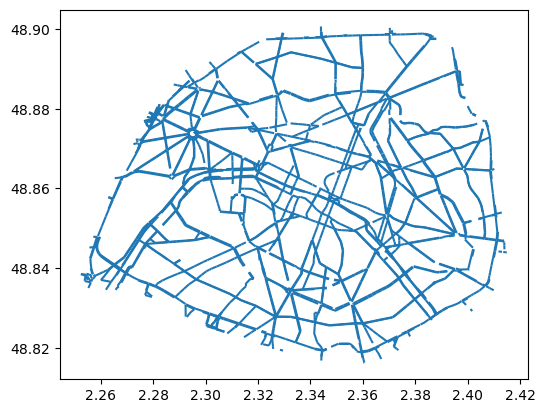

In [8]:
fig, ax = plt.subplots()
df_detectors.plot(ax=ax)

<Axes: >

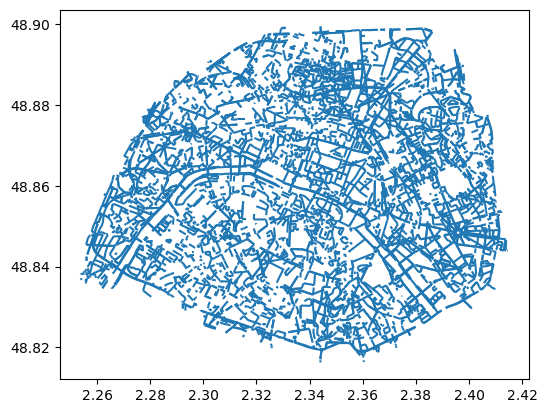

In [9]:
fig, ax = plt.subplots()
df_osm.plot(ax=ax)

In [10]:
# Filter osm network for higher order roads
df_osm_hor = df_osm[
    df_osm["highway"].str.contains("motorway") |
    df_osm["highway"].str.contains("trunk") |
    df_osm["highway"].str.contains("primary") |
    df_osm["highway"].str.contains("secondary") |
    df_osm["highway"].str.contains("tertiary")
]
df_osm_hor = df_osm_hor[df_osm_hor['geometry'].notnull()]

<Axes: >

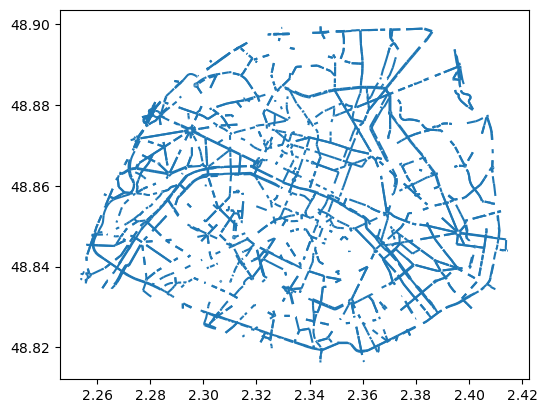

In [11]:
fig, ax = plt.subplots()
df_osm_hor.plot(ax=ax)

## Matching

In [12]:
# Calculate centroids
detector_centroids = np.vstack([
    df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T

osm_centroids = np.vstack([
    df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72663/3904791298.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72663/3904791298.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T


In [13]:
# Calculate orientation

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    
detector_angles = df_detectors["geometry"].apply(angle).values
osm_angles = df_osm_hor["geometry"].apply(angle).values

In [14]:
# Calculate n-to-m distances
centroid_distances = np.zeros((len(detector_centroids), len(osm_centroids)))
angle_distances = np.zeros((len(detector_centroids), len(osm_centroids)))

In [15]:
for k in tqdm(range(len(detector_centroids))):
    centroid_distances[k,:] = la.norm(detector_centroids[k] - osm_centroids, axis = 1)
    angle_distances[k,:] = np.abs(detector_angles[k] - osm_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/2719 [00:00<?, ?it/s]

In [16]:
# Prepare scoring / matching
scores = centroid_distances + alpha * angle_distances

# Deactivate improbable matchings
scores[centroid_distances > maximum_distance] = np.inf
scores[angle_distances > maximum_angle] = np.inf

In [17]:
# Matching process
matchings = []
matched_scores = []

# The idea is relatively simple:
# - Find the matching with the smallest score among those with a finite value
# - Note down the matching, and set all matching containing the two links to Inf
# - Continue until no scores with finite value are left

current = np.count_nonzero(~np.isfinite(scores))

with tqdm(total = np.prod(scores.shape) - current) as progress:
    while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
        index = np.unravel_index(np.argmin(scores), scores.shape)
        matched_scores.append(scores[index])

        # Set both invlved links to Inf
        scores[index[0], :] = np.inf
        scores[:, index[1]] = np.inf
        
        # Manage progress plotting
        update = np.count_nonzero(~np.isfinite(scores))
        
        if update > current:
            progress.update(update - current)
            current = update

        matchings.append(index)
        
matchings = np.array(matchings) # The matchings themselves (index reference, index matsim)
matched_scores = np.array(matched_scores) # The scores of the matchings

  0%|          | 0/866592 [00:00<?, ?it/s]

## Output

In [18]:
# Construct a data set containing all matching information
df_matching = pd.DataFrame({
    "iu_ac": df_detectors.iloc[matchings[:, 0]]["iu_ac"].values,
    "geometry_detector": df_detectors.iloc[matchings[:, 0]]["geometry"].values,
    "osm_id": df_osm_hor.iloc[matchings[:,1]]["osm_id"].values,
    "lanes": df_osm_hor.iloc[matchings[:, 1]]["lanes"].values,
    "highway": df_osm_hor.iloc[matchings[:, 1]]["highway"].values,
    "oneway": df_osm_hor.iloc[matchings[:, 1]]["oneway"].values,
    "length_mapped_osm_street": df_osm_hor.iloc[matchings[:, 1]]["length"].values,
    "score": matched_scores
})
df_matching = df_matching.sort_values(by='iu_ac')

In [19]:
df_matching['length_detector_street'] = df_matching['geometry_detector'].apply(lambda x: line_length_in_meters(x))
df_matching['lanes_mapped'] = df_matching['lanes'].apply(parse_and_average_lanes)

In [20]:
df_matching

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,length_detector_street,lanes_mapped
1482,1,"LINESTRING (2.33342 48.86003, 2.33506 48.85965)",14806,NaN,primary,True,204.263,0.003808,127.877045,NaN
603,10,"LINESTRING (2.34947 48.85648, 2.35059 48.85606)",1169,NaN,primary,True,143.586,0.001123,94.716807,NaN
1126,100,"LINESTRING (2.34994 48.84888, 2.34916 48.84992)",3719,NaN,secondary,True,116.979,0.002275,128.196599,NaN
1153,1005,"LINESTRING (2.33249 48.82783, 2.32726 48.82788...",2916,NaN,secondary,False,147.162,0.002347,418.329528,NaN
1431,1006,"LINESTRING (2.32679 48.82787, 2.32723 48.82780...",3017,NaN,secondary,False,147.162,0.003584,418.199171,NaN
...,...,...,...,...,...,...,...,...,...,...
1704,986,"LINESTRING (2.27109 48.84021, 2.27126 48.84023...",10322,NaN,primary,True,37.536,0.005929,66.719287,NaN
1420,99,"LINESTRING (2.35051 48.84812, 2.34994 48.84888)",978,NaN,secondary,True,53.408,0.003537,94.764298,NaN
830,994,"LINESTRING (2.39934 48.83079, 2.39797 48.83170)",13938,NaN,primary,False,145.294,0.001556,142.898625,NaN
1540,996,"LINESTRING (2.40170 48.82925, 2.40099 48.82974)",14897,NaN,primary,False,173.843,0.004328,75.908464,NaN


In [21]:
df_matched_with_lanes_approximated = approximate_number_of_lanes(df_matching)

In [22]:
# filter out the matches with the highest score
df_matching_best = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['score'] < 0.05]

print(len(df_matched_with_lanes_approximated))
print(len(df_matching_best))

2719
2711


In [23]:
# save the results

df_matching_best.to_csv(output_path + "_best_matches.csv", sep=";", index=False)
df_matched_with_lanes_approximated.to_csv(output_path + ".csv", sep=";", index=False)

In [24]:
df_matched_with_lanes_approximated

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,length_detector_street,lanes_mapped
1482,1,"LINESTRING (2.33342 48.86003, 2.33506 48.85965)",14806,NaN,primary,True,204.263,0.003808,127.877045,3.07947
603,10,"LINESTRING (2.34947 48.85648, 2.35059 48.85606)",1169,NaN,primary,True,143.586,0.001123,94.716807,3.07947
1126,100,"LINESTRING (2.34994 48.84888, 2.34916 48.84992)",3719,NaN,secondary,True,116.979,0.002275,128.196599,2.43750
1153,1005,"LINESTRING (2.33249 48.82783, 2.32726 48.82788...",2916,NaN,secondary,False,147.162,0.002347,418.329528,2.43750
1431,1006,"LINESTRING (2.32679 48.82787, 2.32723 48.82780...",3017,NaN,secondary,False,147.162,0.003584,418.199171,2.43750
...,...,...,...,...,...,...,...,...,...,...
1704,986,"LINESTRING (2.27109 48.84021, 2.27126 48.84023...",10322,NaN,primary,True,37.536,0.005929,66.719287,3.07947
1420,99,"LINESTRING (2.35051 48.84812, 2.34994 48.84888)",978,NaN,secondary,True,53.408,0.003537,94.764298,2.43750
830,994,"LINESTRING (2.39934 48.83079, 2.39797 48.83170)",13938,NaN,primary,False,145.294,0.001556,142.898625,3.07947
1540,996,"LINESTRING (2.40170 48.82925, 2.40099 48.82974)",14897,NaN,primary,False,173.843,0.004328,75.908464,3.07947


In [25]:
# df_comparison = df_detectors.copy()
# df_comparison = pd.merge(df_comparison, df_matching)
# df_comparison.to_file("output/detectors_matched_2_osm.geojson", driver = 'GeoJSON')

In [26]:
# osm_matched_2_detectors = df_osm_hor.copy()
# osm_matched_2_detectors = pd.merge(osm_matched_2_detectors, df_matching)
# osm_matched_2_detectors.to_file(
#     "output/osm_matched_2_detectors.geojson", driver='GeoJSON')